In [110]:
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")
plt.style.use("seaborn-ticks")

#### LJ Units

In [111]:
sigma = 3.4 * 10 ** (-10)  # m
k_B = 1.380649 * 10 ** (-23)  # J/K
T = 120  # K
epsilon = T * k_B  # J
m = 39.948 * 1.66 * 10 ** (-27)  # mass of argon, kg
t = sigma * np.sqrt(m / epsilon)
p = epsilon / sigma ** 3  # Pa

print("Sigma :", sigma)
print("Epsilon :", epsilon)
print("Mass :", m)
print("Time :", t)
print("Temperature :", T)
print("Pressure :", format(p, "E"))

Sigma : 3.4e-10
Epsilon : 1.6567788e-21
Mass : 6.631367999999999e-26
Time : 2.151038666903973e-12
Temperature : 120
Pressure : 4.215293E+07


# Monte Carlo NVT Simulation

## Equilibration

In [112]:
P_eq = np.loadtxt("./data/equilibration/output.epot")
E_eq = np.loadtxt("./data/equilibration/output.pressure")

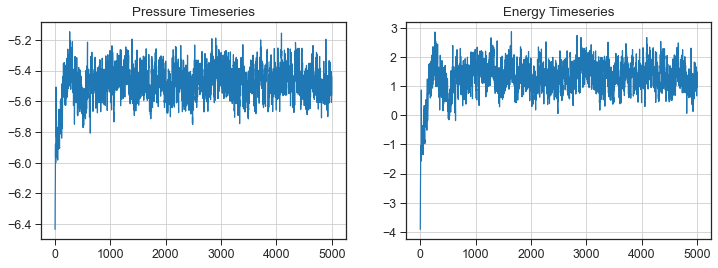

In [113]:
skip = 1
cutoff = 5000
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=P_eq[:cutoff:skip], ax=ax[0])
ax[0].title.set_text("Pressure Timeseries")
ax[0].grid()
sns.lineplot(data=E_eq[:cutoff:skip], ax=ax[1])
ax[1].title.set_text("Energy Timeseries")
ax[1].grid()
plt.show()

**Figure: Pressure and energy timeseries showing that equilibration occurs within about 1000 steps.**

### Data

In [104]:
P = np.loadtxt("./data/timeseries/output.pressure")
E = np.loadtxt("./data/timeseries/output.epot")

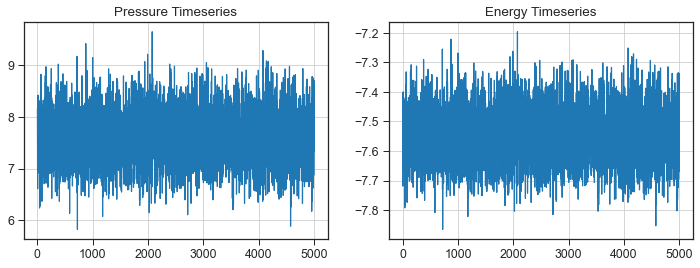

In [105]:
skip = 100
cutoff = None
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=P[:cutoff:skip], ax=ax[0])
ax[0].title.set_text("Pressure Timeseries")
ax[0].grid()
sns.lineplot(data=E[:cutoff:skip], ax=ax[1])
ax[1].title.set_text("Energy Timeseries")
ax[1].grid()
plt.show()

**Figure: The equilibrated timeseries used in the following exercises.**

## Autocorrelation

In [114]:
def autocorr(data, tmax):
    lags = np.arange(tmax)
    ac_series = np.zeros(tmax)
    for i, t in enumerate(lags):
        if t == 0:
            ac_series[i] = np.var(data)
        else:
            T = data.size - t
            corr = np.sum(data[:-t] * data[t:]) / T
            mean_sq = np.sum(data[:-t]) * np.sum(data[t:]) / T ** 2
            ac_series[i] = corr - mean_sq
    ac_series /= np.var(data)
    return ac_series


def negexp(x, a, b):
    return a * np.exp(-b * x)

Correlation time (energy): 9.34 steps
Correlation time (pressure): 9.18 steps


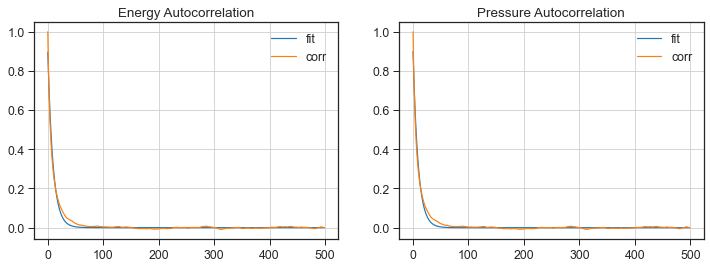

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

N = 500
x = np.arange(N)

pars, cov = curve_fit(negexp, x, autocorr(E, N), bounds=(-1, 1))
sns.lineplot(data=negexp(x, pars[0], pars[1]), ax=ax[0], label="fit")
sns.lineplot(data=autocorr(E, N), ax=ax[0], label="corr")
ax[0].title.set_text("Energy Autocorrelation")
ax[0].legend()
ax[0].grid()
print("Correlation time (energy):", round(1 / pars[1], 2), "steps")

pars, cov = curve_fit(negexp, x, autocorr(P, N), bounds=(0, 1))
sns.lineplot(data=negexp(x, pars[0], pars[1]), ax=ax[1], label="fit")
sns.lineplot(data=autocorr(P, N), ax=ax[1], label="corr")
ax[1].title.set_text("Pressure Autocorrelation")
ax[1].legend()
ax[1].grid()
print("Correlation time (pressure):", round(1 / pars[1], 2), "steps")

plt.show()

**Figure: Autocorrelation curves and their fits, energy and pressure.**

## Blocking Method

In [116]:
def block_error(data, blk_size, n_blks):
    if n_blks == 0:
        return 0
    else:
        ave = np.zeros(n_blks)
        av2 = np.zeros(n_blks)

        for i in range(n_blks):
        
            k = i * blk_size
            sum = np.sum(data[k : k + blk_size])

        ave[i] = sum / blk_size
        av2[i] = (ave[i]) ** 2
        sum = np.sum(ave) / n_blks
        sum_2 = np.sum(av2) / n_blks

        return math.sqrt((sum_2 - sum ** 2) / (n_blks - 1))

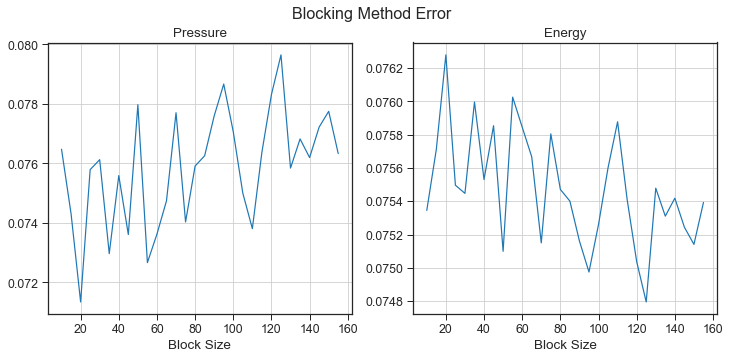

In [117]:
M = 500000  # total number of data points
N = 100
cutoff = 30
block_sizes = np.arange(10, 5000, 5)
errors = np.zeros(block_sizes.size)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Blocking Method Error")

for i, L in enumerate(block_sizes):
    errors[i] = block_error(P, L, N)

sns.lineplot(x=block_sizes[:cutoff], y=errors[:cutoff], ax=ax[0])
ax[0].set(title="Pressure", xlabel="Block Size")
ax[0].grid()

for i, L in enumerate(block_sizes):
    errors[i] = block_error(E, L, N)

sns.lineplot(x=block_sizes[:cutoff], y=errors[:cutoff], ax=ax[1])
ax[1].set(title="Energy", xlabel="Block Size")
ax[1].grid()
plt.show()

## Measurements

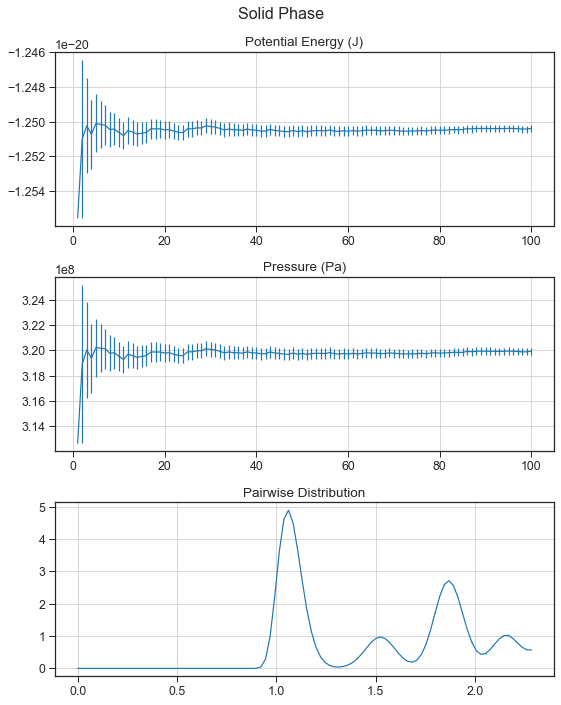

In [43]:
x, V, V_err = np.loadtxt("./data/averages/solid/output.epot.0", usecols=(0, 2, 3), unpack=True)
P, P_err = np.loadtxt("./data/averages/solid/output.pres.0", usecols=(2, 3), unpack=True)
r, g, g_err = np.loadtxt("./data/averages/solid/output.gave.0", usecols=(1, 2, 3), unpack=True)

fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.suptitle("Solid Phase")

axes[0].errorbar(x, V*epsilon, yerr=V_err*epsilon)
axes[0].grid(True)
axes[0].title.set_text("Potential Energy (J)")

axes[1].errorbar(x, P*p, yerr=P_err*p)
axes[1].grid(True)
axes[1].title.set_text("Pressure (Pa)")

axes[2].errorbar(r, g, yerr=g_err)
axes[2].grid(True)
axes[2].title.set_text("Pairwise Distribution")

plt.tight_layout()

**Figure: Energy, pressure, and pairwise distribution (g(r)) in the solid phase.**

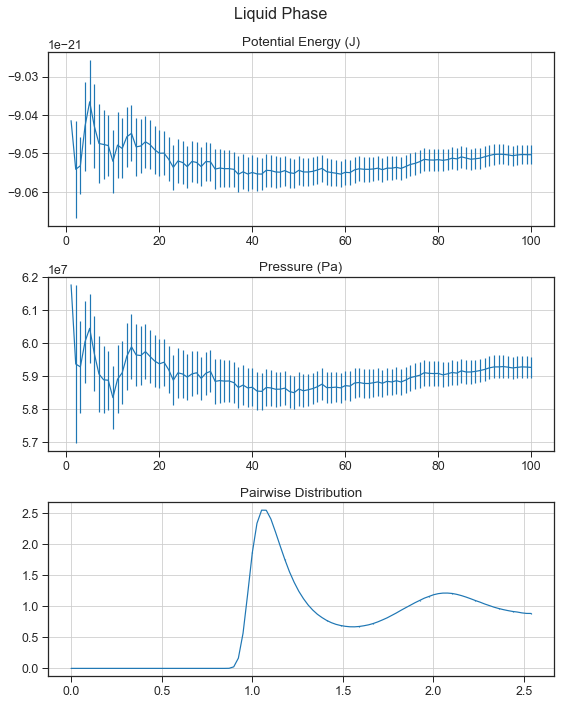

In [44]:
x, V, V_err = np.loadtxt("./data/averages/liquid/output.epot.0", usecols=(0, 2, 3), unpack=True)
P, P_err = np.loadtxt("./data/averages/liquid/output.pres.0", usecols=(2, 3), unpack=True)
r, g, g_err = np.loadtxt("./data/averages/liquid/output.gave.0", usecols=(1, 2, 3), unpack=True)

fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.suptitle("Liquid Phase")

axes[0].errorbar(x, V*epsilon, yerr=V_err*epsilon)
axes[0].grid(True)
axes[0].title.set_text("Potential Energy (J)")

axes[1].errorbar(x, P*p, yerr=P_err*p)
axes[1].grid(True)
axes[1].title.set_text("Pressure (Pa)")

axes[2].errorbar(r, g, yerr=g_err)
axes[2].grid(True)
axes[2].title.set_text("Pairwise Distribution")

plt.tight_layout()

**Figure: Energy, pressure, and pairwise distribution (g(r)) in the liquid phase.**

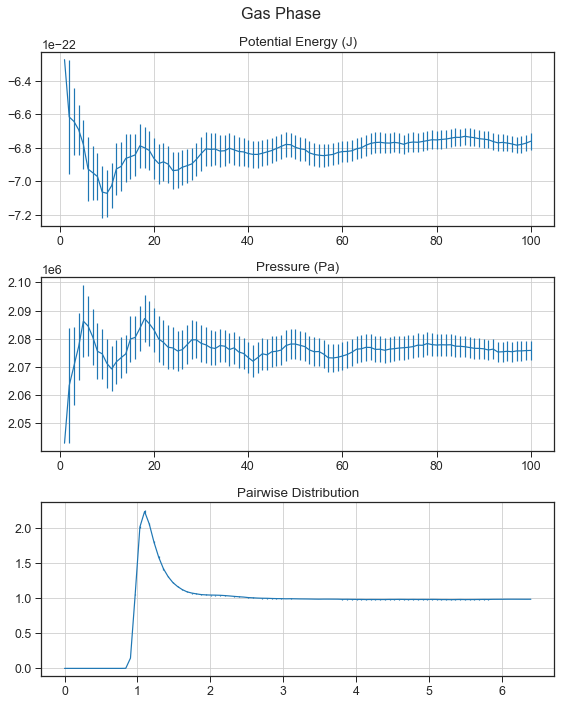

In [26]:
x, V, V_err = np.loadtxt("./data/averages/gas/output.epot.0", usecols=(0, 2, 3), unpack=True)
P, P_err = np.loadtxt("./data/averages/gas/output.pres.0", usecols=(2, 3), unpack=True)
r, g, g_err = np.loadtxt("./data/averages/gas/output.gave.0", usecols=(1, 2, 3), unpack=True)

fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.suptitle("Gas Phase")

axes[0].errorbar(x, V*epsilon, yerr=V_err*epsilon)
axes[0].grid(True)
axes[0].title.set_text("Potential Energy (J)")

axes[1].errorbar(x, P*p, yerr=P_err*p)
axes[1].grid(True)
axes[1].title.set_text("Pressure (Pa)")

axes[2].errorbar(r, g, yerr=g_err)
axes[2].grid(True)
axes[2].title.set_text("Pairwise Distribution")

plt.tight_layout()

**Figure: Energy, pressure, and pairwise distribution (g(r)) in the gas phase.**

# NVT vs NVE

In [118]:
def plot_gr(X, G, GERR, LABEL, AX=None):
    if AX==None:
        AX=plt.gca()
        
    AX.errorbar(X, G, yerr=GERR, label=LABEL)
    AX.grid(True)
    AX.legend()

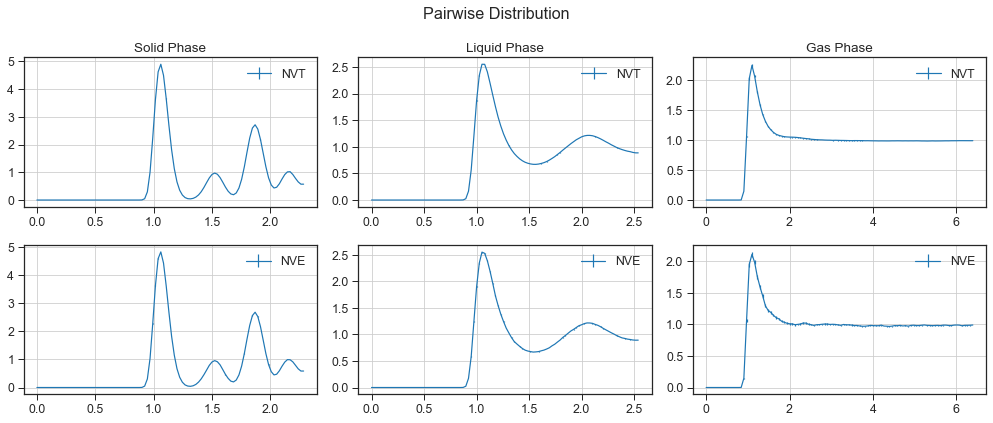

In [119]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

r, g, g_err = np.loadtxt("./data/averages/solid/output.gave.0", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVT", ax[0, 0])
r, g, g_err = np.loadtxt("../esercizio_04/data/solid/output.gave.dat", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVE", ax[1, 0])
r, g, g_err = np.loadtxt("./data/averages/liquid/output.gave.0", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVT", ax[0, 1])
r, g, g_err = np.loadtxt("../esercizio_04/data/liquid/output.gave.dat", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVE", ax[1, 1])
r, g, g_err = np.loadtxt("./data/averages/gas/output.gave.0", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVT", ax[0, 2])
r, g, g_err = np.loadtxt("../esercizio_04/data/gas/output.gave.dat", usecols=(1, 2, 3), unpack=True)
plot_gr(r, g, g_err, "NVE", ax[1, 2])

plt.suptitle("Pairwise Distribution")
ax[0, 0].title.set_text("Solid Phase")
ax[0, 1].title.set_text("Liquid Phase")
ax[0, 2].title.set_text("Gas Phase")
plt.tight_layout()
plt.show()

**Figure: Pairwise distributions coincide excellently for NVE and NVT simulations if the temperatures are compatible (T = \<T\>).**